In [3]:
 cd /content/drive/My Drive/Project/plant-seedlings-classification

/content/drive/My Drive/Project/plant-seedlings-classification


In [4]:
!ls train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
TRAin_DATA_FOLDER= "train"
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

Counting the number of images 

In [8]:
len(images)

4764

Resizing and then saving the images

In [9]:
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

In [10]:
images = [resize_images(img) for img in images]

In [11]:
images[0].shape

(256, 256, 3)

Displaying the resized image

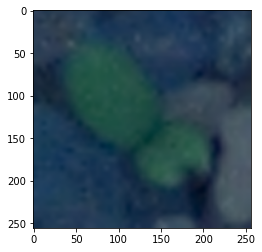

In [12]:
plt.imshow(images[50])

Displaying the number of images in each class

In [13]:
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
  
for label in set(classes):
  print("number of {} images are  -> {}".format(label, len(images[classes == label])))

images shape:  (4764, 256, 256, 3)
classes shape:  (4764,)
number of Black-grass images are  -> 263
number of Maize images are  -> 221
number of Small-flowered Cranesbill images are  -> 506
number of Fat Hen images are  -> 475
number of Common Chickweed images are  -> 611
number of Scentless Mayweed images are  -> 516
number of Loose Silky-bent images are  -> 654
number of Charlock images are  -> 390
number of Sugar beet images are  -> 389
number of Cleavers images are  -> 287
number of Shepherds Purse images are  -> 231
number of Common wheat images are  -> 221


Applying image processing on the dataset

In [14]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [15]:
def segment(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

In [16]:
for indx, image in enumerate(images):
  try:
     images[indx] = segment(image)      
  except:
    print(indx)
    continue
      

Visualizing the data

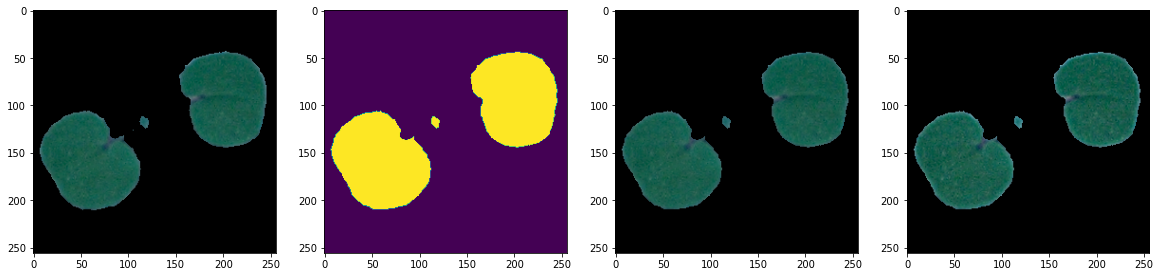

In [17]:
image = images[classes == "Small-flowered Cranesbill"][40]
image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)
fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [18]:
images.shape

(4764, 256, 256, 3)

In [19]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)
y[0]                      

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

Splitting the dataset into training dataset and testing dataset

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)
X_train.shape

(3334, 256, 256, 3)

Generating the validation dataset

In [21]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)
print(X_test.shape)
print(X_val.shape)

(715, 256, 256, 3)
(715, 256, 256, 3)


The CNN model

In [22]:

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Set the CNN model 

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)       

In [23]:
opt = Adam(lr=0.001)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [25]:
history = model.fit(X_train, y_train, epochs = 15, validation_data = (X_val,Y_val),batch_size = batch_size)

Train on 3334 samples, validate on 715 samples
Epoch 1/15
3334/3334 [==============================] - 2177s 653ms/step - loss: 2.4303 - accuracy: 0.1539 - val_loss: 2.4483 - val_accuracy: 0.1636
Epoch 2/15
3334/3334 [==============================] - 2212s 663ms/step - loss: 2.1668 - accuracy: 0.2768 - val_loss: 1.9701 - val_accuracy: 0.3510
Epoch 3/15
3334/3334 [==============================] - 2235s 670ms/step - loss: 1.8178 - accuracy: 0.3680 - val_loss: 1.7667 - val_accuracy: 0.4168
Epoch 4/15
3334/3334 [==============================] - 2206s 662ms/step - loss: 1.6287 - accuracy: 0.4310 - val_loss: 1.9853 - val_accuracy: 0.3105
Epoch 5/15
3334/3334 [==============================] - 2189s 657ms/step - loss: 1.4855 - accuracy: 0.4880 - val_loss: 1.7380 - val_accuracy: 0.3958
Epoch 6/15
3334/3334 [==============================] - 2175s 652ms/step - loss: 1.3378 - accuracy: 0.5612 - val_loss: 1.5344 - val_accuracy: 0.4769
Epoch 7/15
3334/3334 [==============================] - 216

In [26]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
X_test.shape

Test loss: 0.959970520176254
Test accuracy: 0.6629370450973511


(715, 256, 256, 3)

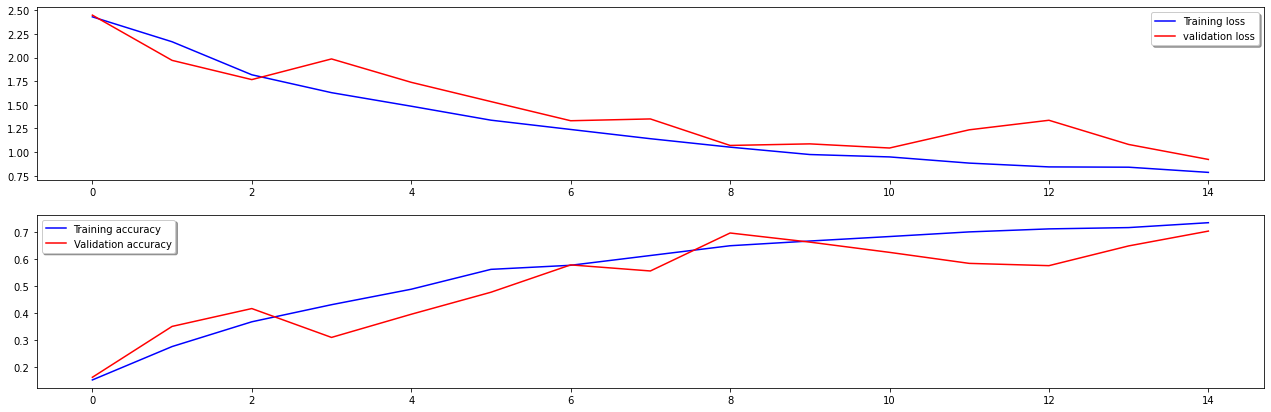

In [29]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [30]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
epochs = 15
batch_size = 38

In [31]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)  


datagen.fit(X_train)

Prediction

In [32]:
Predicted_classes = model.predict_classes(X_test)


In [33]:
wrong_preds = X_test[Predicted_classes != np.argmax(y_test)]

In [34]:
set(Predicted_classes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

Predicted class: Common wheat
Actual class: Loose Silky-bent


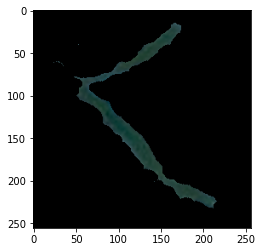

In [35]:
i = 10
pred = model.predict_classes(np.array([wrong_preds[i]]))[0]
act = np.argmax(y_test[i])
print("Predicted class: {}".format(enc.classes_[pred]))
print("Actual class: {}".format(enc.classes_[act]))

plt.imshow(wrong_preds[i])